# Init and aged Vehicle ICA

In [2]:
import os
import sys
import math
sys.path.append(os.path.join(os.getcwd().partition('nature_soh')[0], "nature_soh"))
from src.config_base import GeneralConfig

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator, FixedLocator
import matplotlib.patches as patches
import matplotlib.lines as mlines

In [4]:
from src.data.read_feather import ReadFeather
from src.filtering.filter_methods import FilterMethods
from src.voltage_capacity_analysis.ica import ICA
from src.visualization.config_visualization import VisualizationConfig, instantiate_matplotlib_parameters, cm2inch
instantiate_matplotlib_parameters()
from src.visualization.colormaps import ColorMaps

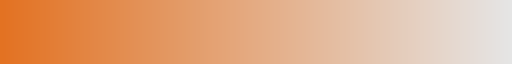

In [5]:
tum_orange_cmap = ColorMaps.orange_tum()
orange_colors = tum_orange_cmap(np.linspace(0,1, 10))
tum_orange_cmap

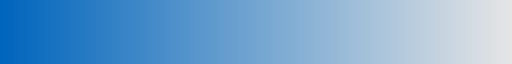

In [6]:
tum_blue_cmap = ColorMaps.blue_tum()
blue_colors = tum_blue_cmap(np.linspace(0,1, 10))
tum_blue_cmap

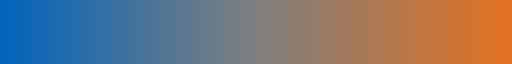

In [7]:
tum_cmap = ColorMaps.blue_orange_tum(grayscale=0.5)
colors = tum_cmap(np.linspace(0,1, 5))
tum_cmap

In [8]:
def filter_func_preprocess(signal):
    perc_filter = 1/100 * len(signal) #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter * len(signal)))
    return filtered_signal

In [9]:
read_feather = ReadFeather()
read_feather.set_filter_U(filter_func_preprocess)
read_feather.set_filter_Q(filter_func_preprocess)

## Load vehicle data

In [11]:
%%capture
df_taycan =  read_feather.read(os.path.join(GeneralConfig.path2data.value,"Taycan","Taycan_JB_13A_CEE7_C36.feather"), lower_voltage=650, upper_voltage=830)
df_taycan_aged =  read_feather.read(os.path.join(GeneralConfig.path2data.value,"Taycan","Porsche_Taycan_JB_10A_CEE7_AMS.feather"),lower_voltage=650, upper_voltage=830)

In [12]:
%%capture
df_vw = read_feather.read(os.path.join(GeneralConfig.path2data.value,"VW","VW_ID3_JB_8A_C40_2021.feather"), lower_voltage=360, upper_voltage=450)
df_vw_aged = read_feather.read(os.path.join(GeneralConfig.path2data.value,"VW","VW_ID3_JB_8A_C40_2024.feather"), lower_voltage=360, upper_voltage=450)

In [13]:
%%capture
df_teslaY = read_feather.read(os.path.join(GeneralConfig.path2data.value,"Tesla","Tesla_Model_Y_JB_8A_CEE7_Miles_2025.feather"), lower_voltage=300, upper_voltage=400)
df_teslaY_aged = read_feather.read(os.path.join(GeneralConfig.path2data.value,"Tesla","Tesla_Model_3_JB_8A_CEE7_2024_Tom_Winkler.feather"), lower_voltage=300, upper_voltage=400)

In [14]:
%%capture
df_tesla_aged = read_feather.read(os.path.join(GeneralConfig.path2data.value,"Tesla","Tesla_JB_6A_CEE7_C57_2025.feather"), lower_voltage=335, upper_voltage=365)

In [15]:
## the sharp voltage increased of LFP cells can be filtered out, if the windowsize is too wide
def filter_func_preprocess_tesla(signal):
    perc_filter = 0.1/100 * len(signal) #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter * len(signal)))
    return filtered_signal

In [16]:
read_feather.set_filter_U(filter_func_preprocess_tesla)
read_feather.set_filter_Q(filter_func_preprocess_tesla)

In [17]:
%%capture
df_tesla = read_feather.read(os.path.join(GeneralConfig.path2data.value,"Tesla","Tesla_JB_6A_CEE7_C57_2021.feather"), lower_voltage=335, upper_voltage=365)

### ICA

In [19]:
def filter_func_v(signal):
    perc_filter = 1 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [20]:
def filter_func_v_post(signal):
    perc_filter = 2 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [21]:
ica_extractor = ICA()
ica_extractor.set_filter(filter_func_v)
ica_extractor.set_post_filter(filter_func_v_post)

In [22]:
ica_taycan, volt_taycan =ica_extractor.get_ica(time=df_taycan["time_h"], capacity=df_taycan["Q"], voltage=df_taycan["U"],crop_volt_V=(0,900))
ica_taycan_aged, volt_taycan_aged =ica_extractor.get_ica(time=df_taycan_aged["time_h"], capacity=df_taycan_aged["Q"], voltage=df_taycan_aged["U"],crop_volt_V=(0,900))

In [23]:
ica_vw, volt_vw =ica_extractor.get_ica(time=df_vw["time_h"], capacity=df_vw["Q"], voltage=df_vw["U"],crop_volt_V=(360,500))
ica_vw_aged, volt_vw_aged =ica_extractor.get_ica(time=df_vw_aged["time_h"], capacity=df_vw_aged["Q"], voltage=df_vw_aged["U"],crop_volt_V=(364,500))

In [24]:
ica_tesla, volt_tesla = ica_extractor.get_ica(time=df_tesla["time_h"], capacity=df_tesla["Q"], voltage=df_tesla["U"],
                                              crop_volt_V=(280,390),postfilter=True,postfilter_volt_range=(350,360))
ica_tesla_aged, volt_tesla_aged = ica_extractor.get_ica(time=df_tesla_aged["time_h"], capacity=df_tesla_aged["Q"], voltage=df_tesla_aged["U"],
                                                        crop_volt_V=(280,390),postfilter=True,postfilter_volt_range=(350,360))

H:\1000-Repositories\nature_soh\src\voltage_capacity_analysis\vca_base.py:21: RuntimeWarning: divide by zero encountered in divide
  return np.gradient(signal) / np.gradient(time)
H:\1000-Repositories\nature_soh\src\voltage_capacity_analysis\ica.py:44: RuntimeWarning: invalid value encountered in divide
  dva = np.divide(diff_voltage,diff_cap)  # (dQ*dt)/(dU*dt) = dQ/dU


In [25]:
ica_teslaY, volt_teslaY =ica_extractor.get_ica(time=df_teslaY["time_h"], capacity=df_teslaY["Q"], voltage=df_teslaY["U"],crop_volt_V=(0,900))
ica_teslaY_aged, volt_teslaY_aged =ica_extractor.get_ica(time=df_teslaY_aged["time_h"], capacity=df_teslaY_aged["Q"], voltage=df_teslaY_aged["U"],crop_volt_V=(0,900))

## Figure

## pOCV

In [28]:
def plot_pocv_vw(axes):
    ax2 = axes.twiny()
    line1 = axes.plot(df_vw["Q"],df_vw["U"],color=VisualizationConfig.TUMblau.value,linewidth=1.5,label="$\ \ \ \ 400\,km$")
    line2 = axes.plot(df_vw_aged["Q"],df_vw_aged["U"],color=VisualizationConfig.TUMorange.value,linewidth=1.5,label="$40500\,km$")
    
    axes.set_ylabel(r"Vehicle voltage in V",fontsize=7)
    #axes.yaxis.set_label_coords(-0.05,0.5)
    axes.set_xlabel("Charged capacity in Ah") 
    axes.set_xlim([0,150])
    tick_positions = np.array([0,50,100,150])
    axes.set_xticks(tick_positions)
    axes.xaxis.set_minor_locator(FixedLocator([25,75,125]))
    axes.set_ylim([360,450])
    tick_positions = np.array([360,390,420,450])
    axes.set_yticks(tick_positions)
    axes.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    axes.tick_params('y', left=True, labelleft=True,right=False, labelright=False)
    axes.grid()
    axes.set_axisbelow(True)
    # secondary x-axes 
    ax2.plot(df_vw["U"].mean()*(df_vw["Q"])/1000,-10*np.ones(len(df_vw["Q"])),color="white",linewidth=1.5)
    ax2.set_xlabel("Charged energy in kWh",fontsize=7)
    ax2.set_xlim(np.array([0,150]))
    tick_positions = np.array([0,50,100,150])
    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels([f"{round(label*df_vw.U.mean()/10000)*10:.0f}" for label in tick_positions])
    ax2.xaxis.set_minor_locator(FixedLocator([25,75,125]))
    
    axes.legend(handles=[line1[0], line2[0]],loc="upper left",fontsize=5,ncols=2,handletextpad=0.4,handlelength=1.5,
               framealpha =1 , fancybox=False,labelspacing=0.2,columnspacing=0.7,edgecolor="black",title=r"$\bf{VW\ ID.3\ Pro\ Performance\ (C/NMC\,532)}$",title_fontsize=5,alignment='center')
    return axes

In [29]:
def plot_pocv_taycan(axes):
    ax2 = axes.twiny()
    line1 = axes.plot(df_taycan["Q"],df_taycan["U"],color=VisualizationConfig.TUMblau.value,linewidth=1.5,label="$10000\,km$")
    line2 = axes.plot(df_taycan_aged["Q"],df_taycan_aged["U"],color=VisualizationConfig.TUMorange.value,linewidth=1.5,label="$70500\,km$")
    
    axes.set_ylabel(r"Vehicle voltage in V",fontsize=7)
    #axes.yaxis.set_label_coords(-0.05,0.5)
    axes.set_xlabel("Charged capacity in Ah") 
    axes.set_xlim([0,120])
    tick_positions = np.array([0,40,80,120])
    axes.set_xticks(tick_positions)
    axes.xaxis.set_minor_locator(FixedLocator([20,60,100]))
    axes.set_ylim([650,830])
    tick_positions = np.array([650,695,740,785,830])
    axes.set_yticks(tick_positions)
    axes.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    axes.tick_params('y', left=True, labelleft=True,right=False, labelright=False)
    axes.grid()
    axes.set_axisbelow(True)
    # secondary x-axes 
    ax2.plot(df_taycan["U"].mean()*(df_taycan["Q"])/1000,-10*np.ones(len(df_taycan["Q"])),color="white",linewidth=1.5)
    ax2.set_xlabel("Charged energy in kWh",fontsize=7)
    ax2.set_xlim([0,120])
    tick_positions = np.array([0,40,80,120])
    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels([f"{round(label*df_taycan.U.mean()/10000)*10:.0f}" for label in tick_positions])
    ax2.xaxis.set_minor_locator(FixedLocator([20,60,100]))
    ax2.tick_params('x',which="both", top=True, labeltop=True,bottom=False, labelbottom=False)
    
    axes.legend(handles=[line1[0], line2[0]],loc="upper left",fontsize=5,ncols=2,handletextpad=0.4,handlelength=1.5,
               framealpha =1 , fancybox=False,labelspacing=0.2,columnspacing=0.7,edgecolor="black",title=r"$\bf{Porsche\ Taycan\ (C/NMC\,622)}$",title_fontsize=5,alignment='center')
    return axes

In [30]:
def plot_pocv_tesla(axes):
    ax2 = axes.twiny()
    line1 = axes.plot(df_tesla["Q"],df_tesla["U"],color=VisualizationConfig.TUMblau.value,linewidth=1.5,label="$\ \ 1000\,km$")
    line2 = axes.plot(df_tesla_aged["Q"],df_tesla_aged["U"],color=VisualizationConfig.TUMorange.value,linewidth=1.5,label="$80100\,km$")
    
    axes.set_ylabel(r"Vehicle voltage in V",fontsize=7)
    #axes.yaxis.set_label_coords(-0.05,0.5)
    axes.set_xlabel("Charged capacity in Ah") 
    axes.set_xlim([0,160])
    tick_positions = np.array([0,40,80,120,160])
    axes.set_xticks(tick_positions)
    axes.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    axes.set_ylim([335,365])
    tick_positions = np.array([335,345,355,365])
    axes.set_yticks(tick_positions)
    axes.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    axes.tick_params('y', left=True, labelleft=True,right=False, labelright=False)
    axes.grid()
    axes.set_axisbelow(True)
    # secondary x-axes 
    ax2.plot(df_tesla["U"].mean()*(df_tesla["Q"])/1000,-10*np.ones(len(df_tesla["Q"])),color="white",linewidth=1.5)
    ax2.set_xlabel("Charged energy in kWh",fontsize=7)
    ax2.set_xlim([0,160])
    tick_positions = np.array([0,40,80,120,160])
    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels([f"{round(label*df_tesla.U.mean()/1000)*1:.0f}" for label in tick_positions[:-1]]+[56])
    ax2.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    ax2.tick_params('x',which="both", top=True, labeltop=True,bottom=False, labelbottom=False)
    
    axes.legend(handles=[line1[0], line2[0]],loc="upper left",fontsize=5,ncols=2,handletextpad=0.4,handlelength=1.5,
               framealpha =1 , fancybox=False,labelspacing=0.05,columnspacing=0.7,edgecolor="black",title=r"$\bf{Tesla\ Model\ 3\ SR+\ (C/LFP)}$",title_fontsize=5,alignment='center')
    return axes

In [31]:
def plot_pocv_teslaY(axes):
    ax2 = axes.twiny()
    line1 = axes.plot(df_teslaY["Q"],df_teslaY["U"],color=VisualizationConfig.TUMblau.value,linewidth=1.5,label="$24800\,km$")
    line2 = axes.plot(df_teslaY_aged["Q"],df_teslaY_aged["U"],color=VisualizationConfig.TUMorange.value,linewidth=1.5,label="$77600\,km$")
    
    axes.set_ylabel(r"Vehicle voltage in V",fontsize=7)
    #axes.yaxis.set_label_coords(-0.05,0.5)
    axes.set_xlabel("Charged capacity in Ah") 
    axes.set_xlim([0,220])
    tick_positions = np.array([0,55,110,165,220])
    axes.set_xticks(tick_positions)
    axes.xaxis.set_minor_locator(FixedLocator([22.5,77.5,132.5,187.5]))
    axes.set_ylim([300,400])
    tick_positions = np.array([300,325,350,375,400])
    axes.set_yticks(tick_positions)
    axes.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    axes.tick_params('y', left=True, labelleft=True,right=False, labelright=False)
    axes.grid()
    axes.set_axisbelow(True)
    # secondary x-axes 
    ax2.plot(df_tesla["U"].mean()*(df_teslaY["Q"])/1000,-10*np.ones(len(df_teslaY["Q"])),color="white",linewidth=1.5)
    ax2.set_xlabel("Charged energy in kWh",fontsize=7)
    ax2.set_xlim([0,220])
    tick_positions = np.array([0,55,110,165,220])
    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels([f"{round(label*df_teslaY.U.mean()/10000)*10:.0f}" for label in tick_positions])
    ax2.xaxis.set_minor_locator(FixedLocator([22.5,77.5,132.5,187.5]))
    ax2.tick_params('x',which="both", top=True, labeltop=True,bottom=False, labelbottom=False)

    axes.legend(handles=[line1[0], line2[0]],loc="upper left",fontsize=5,ncols=2,handletextpad=0.4,handlelength=1.5,
               framealpha =1 , fancybox=False,labelspacing=0.2,columnspacing=0.7,edgecolor="black",title=r"$\bf{Tesla\ Model\ Y\ LR\ (C/NMC\,811)}$",title_fontsize=5,alignment='center')
    return axes

## Features of interest pOCV

In [33]:
def add_FOI_vw_pocv(axes):
    deltaQ = df_vw.Q.max() - df_vw_aged.Q.max()
    deltaE = df_vw.E.max() - df_vw_aged.E.max()
    rectangle = patches.Rectangle((df_vw_aged.Q.max(),360), deltaQ, 450-360,fc="lightgray",ec="lightgray",alpha=0.7)
    axes.add_artist(rectangle)
    axes.annotate(f'$\Delta Q$ = {deltaQ:.1f}$\,Ah$ | $\Delta E$ = {deltaE:.1f}$\,kWh$',
                  (0.6, 0.02), xycoords=rectangle,rotation=90, annotation_clip=True,fontsize=5,
                 horizontalalignment = "center", verticalalignment = "bottom")
    #axes.annotate(text='', xy=(145,440), xytext=(115,440), arrowprops=dict(arrowstyle='<|-', shrinkA=0, shrinkB=0,facecolor="k"))
    #axes.annotate(text=f'$\Delta Q$ = {deltaQ:.1f}$\,Ah$'+'\n'+f'$\Delta E$ = {deltaE:.1f}$\,kWh$', xy=(150,420),horizontalalignment="right",verticalalignment="bottom",fontsize=5)#,bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0.7))
    return axes

In [34]:
def add_FOI_taycan_pocv(axes):
    deltaQ = df_taycan.Q.max() - df_taycan_aged.Q.max()
    deltaE = df_taycan.E.max() - df_taycan_aged.E.max()
    rectangle = patches.Rectangle((df_taycan_aged.Q.max(),650), deltaQ, 830-650,fc="lightgray",ec="lightgray",alpha=0.7)
    axes.add_artist(rectangle)
    axes.annotate(f'$\Delta Q$ = {deltaQ:.1f}$\,Ah$ | $\Delta E$ = {deltaE:.1f}$\,kWh$',
                  (0.6, 0.02), xycoords=rectangle,rotation=90, annotation_clip=True,fontsize=5,
                 horizontalalignment = "center", verticalalignment = "bottom")
    # axes.annotate(text='', xy=(115,820), xytext=(90,820), arrowprops=dict(arrowstyle='<|-', shrinkA=0, shrinkB=0,facecolor="k"))
    # axes.annotate(text=f'$\Delta Q$ = {deltaQ:.1f}$\,Ah$'+'\n'+f'$\Delta E$ = {deltaE:.1f}$\,kWh$', xy=(120,785),horizontalalignment="right",verticalalignment="bottom",fontsize=5)#,bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0.7))
    return axes

In [35]:
def add_FOI_tesla_pocv(axes):
    deltaQ = df_tesla.Q.max() - df_tesla_aged.Q.max()
    deltaE = df_tesla.E.max() - df_tesla_aged.E.max()
    rectangle = patches.Rectangle((df_tesla_aged.Q.max(),335), deltaQ, 365-335,fc="lightgray",ec="lightgray",alpha=0.7)
    axes.add_artist(rectangle)
    axes.annotate(f'$\Delta Q$ = {deltaQ:.1f}$\,Ah$ | $\Delta E$ = {deltaE:.1f}$\,kWh$',
                  (0.6, 0.02), xycoords=rectangle,rotation=90, annotation_clip=True,fontsize=5,
                 horizontalalignment = "center", verticalalignment = "bottom",bbox=dict(boxstyle='square,pad=0',fc='lightgray', ec='none', alpha=0.6))
    # axes.annotate(text='', xy=(159,363), xytext=(140,363), arrowprops=dict(arrowstyle='<|-', shrinkA=0, shrinkB=0,facecolor="k"))
    # axes.annotate(text=f'$\Delta Q$ = {deltaQ:.1f}$\,Ah$'+'\n'+f'$\Delta E$ = {deltaE:.1f}$\,kWh$', xy=(121,357.5),horizontalalignment="left",verticalalignment="bottom",fontsize=5)#,bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0.7))
    return axes

In [36]:
def add_FOI_teslaY_pocv(axes):
    deltaQ =  df_teslaY.Q.max() - df_teslaY_aged.Q.max() #
    deltaE = df_teslaY.E.max() - df_teslaY_aged.E.max()
    rectangle = patches.Rectangle((df_teslaY_aged.Q.max(),300), deltaQ+1, 400-300,fc="lightgray",ec="lightgray",alpha=0.7)
    axes.add_artist(rectangle)
    axes.annotate(f'$\Delta Q$ = {deltaQ:.1f}$\,Ah$ | $\Delta E$ = {deltaE:.1f}$\,kWh$',
                  (0.6, 0.02), xycoords=rectangle,rotation=90, annotation_clip=True,fontsize=5,
                 horizontalalignment = "center", verticalalignment = "bottom")
    # axes.annotate(text='', xy=(195,395), xytext=(155,395), arrowprops=dict(arrowstyle='<|-', shrinkA=0, shrinkB=0,facecolor="k"))
    # axes.annotate(text=f'$\Delta Q$ = {deltaQ:.1f}$\,Ah$'+'\n'+f'$\Delta E$ = {deltaE:.1f}$\,kWh$', xy=(200,375),horizontalalignment="right",verticalalignment="bottom",fontsize=5)#,bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0.7))
    return axes

## ICA

In [38]:
def plot_ica_vw(axes):
    mask_init = ica_vw<4.48
    mask_aged= ica_vw_aged<4.48
    axes.plot(volt_vw[mask_init],ica_vw[mask_init],color=VisualizationConfig.TUMblau.value)
    axes.plot(volt_vw_aged[mask_aged],ica_vw_aged[mask_aged],color=VisualizationConfig.TUMorange.value)
    
    axes.set_ylabel(r"$\frac{dQ}{dU}$ in $\frac{Ah}{V}$",fontsize=7)
    axes.set_xlabel(r"Vehicle voltage in V",fontsize=7) 
    
    axes.set_ylim([0,5])
    tick_positions =np.array([0,1,2,3,4,5])
    axes.set_yticks(tick_positions)
    axes.set_xlim([360,450])
    tick_positions = np.array([360,390,420,450])
    axes.set_xticks(tick_positions)
    axes.grid(axis='both')
    axes.set_axisbelow(True)
    return axes

In [39]:
def plot_ica_taycan(axes):
    mask_init = ica_taycan<4.48
    mask_aged= ica_taycan_aged<4.48
    axes.plot(volt_taycan[mask_init],ica_taycan[mask_init],color=VisualizationConfig.TUMblau.value)
    axes.plot(volt_taycan_aged[mask_aged],ica_taycan_aged[mask_aged],color=VisualizationConfig.TUMorange.value)
    
    axes.set_ylabel(r"$\frac{dQ}{dU}$ in $\frac{Ah}{V}$",fontsize=7)
    axes.set_xlabel(r"Vehicle voltage in V",fontsize=7) 
    axes.set_xlim([650,830])
    tick_positions = np.array([650,695,740,785,830])
    axes.set_xticks(tick_positions)
    
    axes.set_ylim([0,2])
    tick_positions =np.array([0,0.5,1,1.5,2])
    axes.set_yticks(tick_positions)
   
    axes.grid(axis='both')
    axes.set_axisbelow(True)
    return axes

In [104]:
def plot_ica_tesla(axes):
    mask_init = ica_tesla<1000
    mask_aged= ica_tesla_aged<1000
    axes.plot(volt_tesla[mask_init],ica_tesla[mask_init],color=VisualizationConfig.TUMblau.value)
    axes.plot(volt_tesla_aged[mask_aged],ica_tesla_aged[mask_aged],color=VisualizationConfig.TUMorange.value)
    
    axes.set_ylabel(r"$\frac{dQ}{dU}$ in $\frac{Ah}{V}$",fontsize=7)
    axes.set_xlabel(r"Vehicle voltage in V",fontsize=7) 
    axes.set_xlim([335,365])
    tick_positions = np.array([335,345,355,365])
    axes.set_xticks(tick_positions)
    
    axes.set_ylim([0,100])
    tick_positions =np.array([0,25,50,75,100])
    axes.set_yticks(tick_positions)
    
    axes.grid(axis='both')
    axes.set_axisbelow(True)
    return axes

In [40]:
def plot_ica_teslaY(axes):
    mask_init = ica_teslaY<15
    mask_aged= ica_teslaY_aged<15
    axes.plot(volt_teslaY[mask_init],ica_teslaY[mask_init],color=VisualizationConfig.TUMblau.value)
    axes.plot(volt_teslaY_aged[mask_aged],ica_teslaY_aged[mask_aged],color=VisualizationConfig.TUMorange.value)
    
    axes.set_ylabel(r"$\frac{dQ}{dU}$ in $\frac{Ah}{V}$",fontsize=7)
    axes.set_xlabel(r"Vehicle voltage in V",fontsize=7) 
    
    axes.set_ylim([0,16])
    tick_positions =np.array([0,4,8,12,16])
    axes.set_yticks(tick_positions)
    axes.set_xlim([300,400])
    tick_positions = np.array([300,325,350,375,400])
    axes.set_xticks(tick_positions)
    axes.grid(axis='both')
    axes.set_axisbelow(True)
    return axes

## Features of interest ICA

In [42]:
def add_FOI_vw_dva(axes, scatter_dict):
    
    return axes

In [43]:
def add_FOI_taycan_dva(axes,scatter_dict):
    
    return axes

In [44]:
def add_FOI_tesla_dva(axes,scatter_dict):
    
    return axes

In [45]:
def add_FOI_teslaY_dva(axes,scatter_dict):
    
    return axes

## Plots

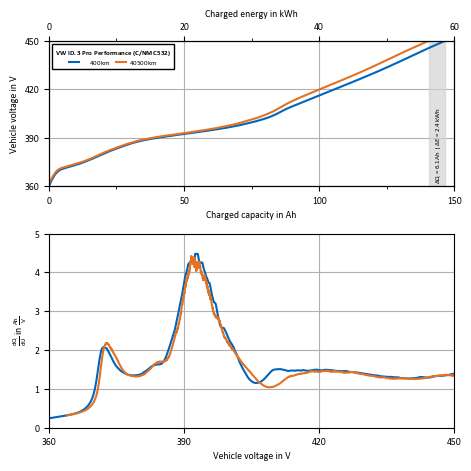

In [47]:
fig, axes= plt.subplots(2,1,
                        figsize=(cm2inch(12),
                                cm2inch(12)),height_ratios=[1.5,2])

axes[0] = plot_pocv_vw(axes[0])
axes[0] = add_FOI_vw_pocv(axes[0])

axes[1] =  plot_ica_vw(axes[1])
plt.tight_layout()
# fig.savefig(os.path.join(GeneralConfig.path2figures.value,"04-POCV_soh_assessment.pdf"))
#fig.savefig(os.path.join(GeneralConfig.path2figures.value,"04-POCV_soh_assessment.png"),dpi=300, pad_inches = 0)

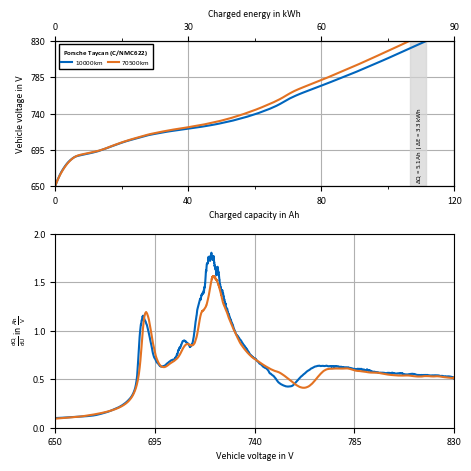

In [48]:
fig, axes= plt.subplots(2,1,
                        figsize=(cm2inch(12),
                                cm2inch(12)),height_ratios=[1.5,2])

axes[0] = plot_pocv_taycan(axes[0])
axes[0] = add_FOI_taycan_pocv(axes[0])

axes[1] =  plot_ica_taycan(axes[1])
plt.tight_layout()

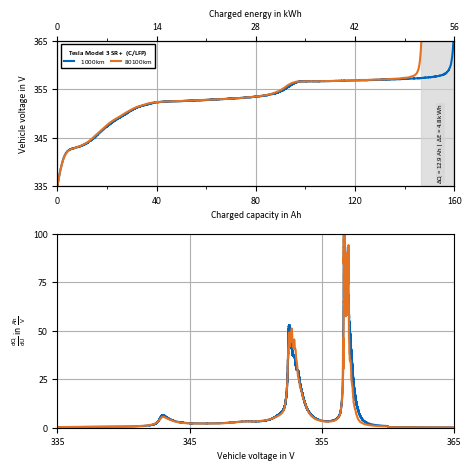

In [106]:
fig, axes= plt.subplots(2,1,
                        figsize=(cm2inch(12),
                                cm2inch(12)),height_ratios=[1.5,2])

axes[0] = plot_pocv_tesla(axes[0])
axes[0] = add_FOI_tesla_pocv(axes[0])

axes[1] =  plot_ica_tesla(axes[1])
plt.tight_layout()

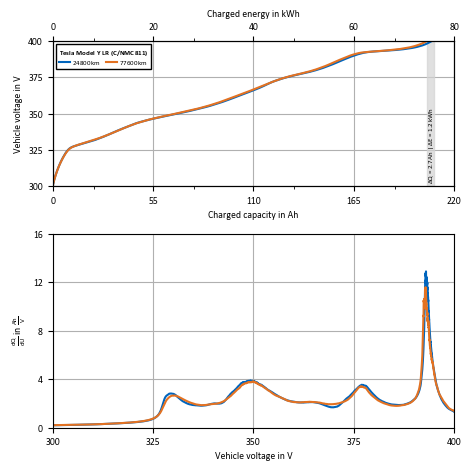

In [51]:
fig, axes= plt.subplots(2,1,
                        figsize=(cm2inch(12),
                                cm2inch(12)),height_ratios=[1.5,2])

axes[0] = plot_pocv_teslaY(axes[0])
axes[0] = add_FOI_teslaY_pocv(axes[0])

axes[1] =  plot_ica_teslaY(axes[1])
plt.tight_layout()